# Notebook : EEG signals classification using Pretrained Model

The goal of this practical course is to decode information from an non-invasive cerebral signal : Electroencephalogram (EEG). To this aim, we are going to implement a classification task using a model based on the GPT (Generative Pre-Trained Tranformers) architecture. This model has been Pretrained on a large amount of EEG data. Our goal today is to finetune this model to use it as an EEG classifier. 

In [1]:
!pip install numpy==1.26.3, torch==2.8.0, scikit-learn==1.6.1, pandas==2.3.3, matplotlib==3.9.4, transformers==4.29.2
!pip install --upgrade accelerate
!pip install transformers==4.29.2 --force-reinstall
!pip install tf-keras

  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.3.0 requires numpy>=1.26.4, but you have numpy 1.26.3 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.3 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.3 which is incompatible.
tetgen 0.6.7 requires numpy<3,>=2, but you have numpy 1.26.3 which is incompatible.
obspy 1.4.2 requires sqlalchemy<2, but you have sqlalchemy 2.0.43 which is incompatible.
pytesmo 0.18.0 requires numpy>=2.0, but you have numpy 1.2

In [1]:
import os
import sys
home = os.environ["HOME"]
python_imports = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder"
cache_root = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/"
sys.path.append(python_imports)

In [2]:
os.getcwd()

'/home/jovyan/neuro-eeg'

In [3]:
import numpy as np
import torch
import os
import sys 
sys.path.insert(0,os.path.join(python_imports,'NeuroGPT_mini/') )
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score
import random
import json

### Import related to Transformer model (from files located in /NeuroGPT directory)

from encoder.conformer_braindecode import EEGConformer
from decoder.make_decoder import make_decoder
from embedder.make import make_embedder
from trainer.make import make_trainer
from trainer.base import Trainer
from decoder.unembedder import make_unembedder
import pandas as pd
from typing import Dict
from dataloader.MIdataset import MotorImageryDataset
with open(os.path.join(python_imports,"NeuroGPT_mini/config.json"), "r", encoding="utf-8") as f:
    config = json.load(f)


import matplotlib.pyplot as plt

2026-01-25 15:58:51.992725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/micromamba/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/micromamba/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  w

## Part 1 : Introduction and Motivation 

Electroencephalography (EEG) records the brain’s electrical activity using electrodes placed on the scalp. These signals reflect how different brain regions communicate and are widely used in neuroscience, medicine, and brain–computer interfaces (BCI). A BCI allows direct interaction between the brain and a computer by decoding EEG patterns into commands. It enables applications such as neuroprosthetic control, emotion recognition, or cognitive state monitoring.

![EEG](../../../../shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder//NeuroGPT_mini/EEG.png)

*Figure: EEG recording*

EEG signals are noisy, non-stationary, and highly individual, making robust decoding a challenging task. Deep learning has emerged as a powerful solution to this problem. Neural networks can automatically learn complex spatiotemporal features from raw EEG data, often more efficient than traditional handcrafted feature extraction methods. 

Architectures inspired by natural language processing—such as transformers and GPT-based models—have shown remarkable ability to model long-range dependencies and sequential patterns in EEG signals, analogous to understanding contextual relationships in language.

## Part 2 : The Dataset

### Brain-Computer Interface

This dataset in part of a set of datasets recorded in 2008 for a BCI Competition. These competitions aims to compare performances of models on different tasks consisting in analysing non-invasive signals from the brain (here, EEGs) to translate them into commands for an external device. 
This dataset is, more preciselly, a Motor-Imagery dataset : EEG signals were recorded while subjects were imaginating themselves moving a certain part of their body. Thus, the classification task aims to recorver which part of the body were the one imagined by the subject from his EEG signal. 

### Experimental Paradigm

This data set consists of EEG data from 9 subjects. The cue-based BCI paradigm consisted of the imagination of movement of : 
* left hand (class 1),
* right hand (class 2),
* both feet (class 3),
* tongue (class 4).

Two sessions on different days were recorded for each subject. Each session is comprised of 6 runs separated by short breaks. One run consists of 48 trials (12 for each of the four possible classes), yielding a total of 288 trials per session.

### Exploring data format

In the dataset file `bciiv2a_eeg_npz` each file is named as `A01T.npz` or `A01E.npz`. each file contain all the EEG data for each subject. 

In [4]:

config_path = {"dst_data_path" : os.path.join(python_imports, "bciiv2a_eeg_npz/"),
         "pretrained_model" : os.path.join(python_imports, "NeuroGPT_mini/pytorch_model.bin"), 
         "log_dir" :os.path.join(python_imports,"training_logs/")}


In [7]:
# Explore the raw EEG signal : print the type of python object, the shape, and the 5 first time-points

"""### eeg_shape = ?? 
# YOUR CODE HERE
print(type(eeg_data))

for key in eeg_data:
    obj = eeg_data[key]
    
    print(f"Key: '{key}'")
    print(f"Shape: {obj.shape}")
    
    if obj.size >= 5:
        print(f"{obj[:5]}")
    else:
        print(f"{obj}")
    
    print("\n")
"""

'### eeg_shape = ?? \n# YOUR CODE HERE\nprint(type(eeg_data))\n\nfor key in eeg_data:\n    obj = eeg_data[key]\n\n    print(f"Key: \'{key}\'")\n    print(f"Shape: {obj.shape}")\n\n    if obj.size >= 5:\n        print(f"{obj[:5]}")\n    else:\n        print(f"{obj}")\n\n    print("\n")\n'

### MotorImageryDataset Class Overview

**However, the data in this previous shape are raw and not adapted to be used as inputs for our decoding model. Thus, we have to implement a DataLoader object.** 

The `MotorImageryDataset` class provides a flexible interface to **load, preprocess, and format EEG data** for training or evaluating deep learning models.  

It extends PyTorch’s `Dataset` to efficiently handle EEG recordings of this dataset and have task-specific logic to manage event markers, labels, and trial segmentation.  
It automates:

- Loading raw EEG `.npy` files containing multiple trials for each subject
- Reordering channels into a consistent montage
- Extracting trials based on event markers  
- Segmenting (chunking) long EEG signals into smaller overlapping windows  
- Normalizing signals  using z-score normalization per channel . This ensures each channel has zero mean and unit variance, stabilizing model training.
- Applying spatial projection matrices to match pretrained model configurations  
- Preparing inputs and attention masks suitable for transformer or GPT-based models


In [9]:
# Compute the dataset (train, test, validation) 
downstream_path = config_path["dst_data_path"]
filenames = sorted(os.listdir(downstream_path))[:18]
print("Files from all the subjects : ", filenames)
train_folds = []
test_folds = []

for i in range(9):
    train_files = filenames[0:i*2] + filenames[i*2+2:]
    test_files = filenames[i*2 : i*2+2]


print("Train dataset : ")
print(train_files)


train_dataset = MotorImageryDataset(train_files, root_path=downstream_path)


print("Test dataset :")
print(test_files)

# On the way, compute the test dataset as :

## TO DO : instanciate a MotorImageryDataset object but with the testing files
# test_dataset = ... 
# YOUR CODE HERE
test_dataset = MotorImageryDataset(test_files, root_path=downstream_path)

validation_dataset = test_dataset

Files from all the subjects :  ['A01E.npz', 'A01T.npz', 'A02E.npz', 'A02T.npz', 'A03E.npz', 'A03T.npz', 'A04E.npz', 'A04T.npz', 'A05E.npz', 'A05T.npz', 'A06E.npz', 'A06T.npz', 'A07E.npz', 'A07T.npz', 'A08E.npz', 'A08T.npz', 'A09E.npz', 'A09T.npz']
Train dataset : 
['A01E.npz', 'A01T.npz', 'A02E.npz', 'A02T.npz', 'A03E.npz', 'A03T.npz', 'A04E.npz', 'A04T.npz', 'A05E.npz', 'A05T.npz', 'A06E.npz', 'A06T.npz', 'A07E.npz', 'A07T.npz', 'A08E.npz', 'A08T.npz']
Number of subjects loaded:  16
Test dataset :
['A09E.npz', 'A09T.npz']
Number of subjects loaded:  2


## Part 3 : Instanciate the GPT-based model 

**Neuro-GPT** framework is a model combining an **EEG encoder** and a **GPT-style decoder** to learn causal representations of brain activity.  
It uses a **two-stage training pipeline**:

1. **Pre-training (Self-supervised CSM)** where the model learns general EEG representations without labels.
2. **Fine-tuning (Supervised Decoding)** where the pre-trained model is adapted to labeled classification tasks.


### Model Overview

![NeuroGPT Model Architecture](../../../../shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/NeuroGPT.png)

*Figure: Overview of the Neuro-GPT architecture integrating EEG encoder, causal masking, and GPT modules.*


### Stage 1 : Pre-training (CSM: Causal Sequence Masking)

**This stage has already been made and is not performed in this notebook : instead you can find the pretrained weights of the model. It is a 'checkpoint' for the model : when these weights are loaded, the model recovers the information from the pre-training phase. Descrition of the Stage 1 is only informative**  

It learns general spatio-temporal representations of EEG signals through **self-supervised learning**, without requiring labels.

1. EEG Encoder

- The raw EEG signals are split into N temporal chunks:
![](../../../../shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/d1d2.png)
- Each chunk is of dimention C x T , where:
  -  C : number of EEG channels  
  -  T : time samples in each chunk  

Each chunk is processed through:
- **Temporal Convolutions** → capture short-term temporal structure.  
- **Spatial Convolutions** → learn inter-channel dependencies.  
- **Self-Attention Layers** → integrate temporal context within the chunk.

The encoder outputs embeddings:
![](../../../../shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/HD1.png)
where \( H(\cdot) \) is the learned mapping from raw EEG to embedding space.

2. Causal Masking (CSM Mechanism)

To pre-train the model, each embedding sequence is masked progressively to enforce causal prediction:


\begin{align*}
\{H(D_1), M, 0, \ldots, 0\} \\
\{H(D_1), H(D_2), M, 0, \ldots, 0\} \\
\vdots \\
\{H(D_1), H(D_2), \ldots, H_{N-1}, M\}
\end{align*}


where:
- \( M \): learnable mask token  
- \( 0 \): zero-padding (no access to future tokens)

Each masked sequence is used as input to the GPT decoder, which attempts to reconstruct the masked token.
The self-supervised loss encourages the model to predict masked embeddings using past context.

![](../../../../shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/causalMasking.png)

*Figure: Causal Masking : for a sequence with four to-
kens (chunks). The sequence is duplicated three times and
progressively is masked each duplicated sequence*

3. GPT Decoder (Transformer)

- A decoder-only transformer(GPT-style) processes the masked embeddings.  
- Self-attention layers capture dependencies between EEG tokens over time.  
- Unlike BERT (which uses bidirectional context), GPT predicts next tokens using only past information, ensuring temporal causality.

**Wrap-Up** : the objective of the pre-training phase is Causal Reconstruction





### Stage 2 : Fine-tuning (Decoding Training) --> What we are doing to do in the next parts of this notebook


It adapt the **pre-trained Neuro-GPT** (EEG encoder + GPT) to a **specific supervised EEG decoding task**, such as motor imagery or cognitive state classification.

1. Load Pre-trained Weights 
   - Initialize the model with parameters obtained from CSM pre-training.

2. Add a Classification Head
   - On top of the encoder (or combined encoder-GPT output), attach a decoder head (e.g., MLP + softmax) to predict class labels.

3. Fine-tune the Entire Network 
   - Optionally freeze lower encoder layers to retain learned representations.  
   - Train using labeled EEG data with a **cross-entropy loss**.

---

- The pre-trained model provides context-aware EEG embeddings that already encode temporal and spatial dependencies.
- Fine-tuning adapts these embeddings to task-specific discriminative features.
- This significantly reduces labeled data requirements and improves downstream EEG decoding accuracy.

---



### Overview on the Model class : 

In [10]:
class Model(torch.nn.Module):
    """
    Create Model object from embedder, decoder,
    and unembedder (if not None).

    Args
    ----
    embedder: src.embedder.make_embedder
        Instance of embedder class.
    decoder: src.decoder.make_decoder
        Instance of decoder class.
    unembedder: src.unembedder.make_unembedder
        Instance of unembedder class.
        Only added to model if not None.

    Methods
    ----
    forward(batch: Dict[str, torch.tensor])
        Forward pass of model.
    prep_batch(batch: Dict[str, torch.tensor])
        Prepare batch for forward pass.
    compute_loss(batch: Dict[str, torch.tensor])
        Compute training loss.
    from_pretrained(pretrained_path: str)
        Load pretrained model from pretrained_path.
        Needs to point to pytorch_model.bin file 
    """
    def __init__(
        self,
        encoder: torch.nn.Module,
        embedder: torch.nn.Module,
        decoder: torch.nn.Module,
        unembedder: torch.nn.Module = None
        ) -> torch.nn.Module:
        
        super().__init__()
        self.name = f'Embedder-{embedder.name}_Decoder-{decoder.name}'
        self.encoder = encoder
        self.embedder = embedder
        self.decoder = decoder
        self.unembedder = unembedder
        self.is_decoding_mode = False
        self.ft_only_encoder = False

    def from_pretrained(
        self,
        pretrained_path: str
        ) -> None:
        """Load pretrained model from pretrained_path.
        Needs to point to pytorch_model.bin file.
        """
        print(
            f'Loading pretrained model from {pretrained_path}'
        )

        if next(self.parameters()).is_cuda:
            pretrained = torch.load(pretrained_path)

        else:
            pretrained = torch.load(pretrained_path, map_location=torch.device('cpu'))
        
        for k in self.state_dict():
            
            if k in pretrained:
                assert pretrained[k].shape == self.state_dict()[k].shape,\
                    f'{k} shape mismatch between pretrained model and current model '+\
                    f'{pretrained[k].shape} vs {self.state_dict()[k].shape}'
        
        for k in pretrained:     
            if k not in self.state_dict():
                warnings.warn(
                    f'Warning: /!\ Skipping {k} from {pretrained_path} '\
                    'because it is not part of the current model'
                )

        # we set strict=False, because we can be sure
        # that all relevant keys are in pretrained
        self.load_state_dict(pretrained, strict=False)
        
    def switch_ft_mode(self, ft_encoder_only=False):
        self.ft_only_encoder = ft_encoder_only

    def switch_decoding_mode(
        self,
        is_decoding_mode: bool = False,
        num_decoding_classes: int = None
        ) -> None:
        """Switch model to decoding model or back to training mode.
        Necessary to adapt pre-trained models to downstream
        decoding tasks.
        
        Args
        ----
        is_decoding_mode: bool
            Whether to switch to decoding mode or not.
        num_decoding_classes: int
            Number of classes to use for decoding.    
        """
        self.is_decoding_mode = is_decoding_mode
        
        self.embedder.switch_decoding_mode(is_decoding_mode=is_decoding_mode)
        self.decoder.switch_decoding_mode(
            is_decoding_mode=is_decoding_mode,
            num_decoding_classes=num_decoding_classes
        )

    def compute_loss(
        self,
        batch: Dict[str, torch.tensor],
        return_outputs: bool = False
        ) -> Dict[str, torch.tensor]:
        """
        Compute training loss, based on 
        embedder's training-style.

        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        return_outputs: bool
            Whether to return outputs of forward pass
            or not. If False, only loss is returned.

        Returns
        ----
        losses: Dict[str, torch.tensor]
            Training losses.
        outputs: torch.tensor
            Outputs of forward pass.
        """
        (outputs, batch) = self.forward(
            batch=batch,
            return_batch=True
        )
        losses = self.embedder.loss(
            batch=batch,
            outputs=outputs
        )

        return (losses, outputs) if return_outputs else losses

    def prep_batch(
        self,
        batch: Dict[str, torch.tensor]
        ) -> Dict[str, torch.tensor]:
        """Prepare input batch for forward pass.
        Calls src.embedder.prep_batch.
        
        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        """
        return self.embedder.prep_batch(batch=dict(batch))

    def forward(
        self,
        batch: Dict[str, torch.tensor],
        prep_batch: bool = True,
        return_batch: bool = False
        ) -> torch.tensor:
        """
        Forward pass of model.
        
        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        prep_batch: bool
            Whether to prep batch for forward pass
            by calling self.embedder.prep_batch
        return_batch: bool
            Whether to return batch after forward pass
            or not. If False, only outputs of forward pass
            are returned.

        Returns
        ----
        outputs: torch.tensor
            Outputs of forward pass.
        batch: Dict[str, torch.tensor]
            Input batch (as returned by prep_batch, 
            if prep_batch is True)
        """
        
        if self.encoder is not None:
            #before prep_batch masking and things, we need to first let the splitted chunks of raw input through the encoder
            features = self.encoder(batch['inputs'])
            #attempt for trying fine-tune only the encoder, but the encoder cannot combine information across chunks.
            if self.is_decoding_mode and self.ft_only_encoder:
                outputs={'outputs': features, 'decoding_logits': features}
                return (outputs, batch) if return_batch else outputs

            b, f1, f2 = features.size()
            nchunks = batch['inputs'].size()[1]
            batch['inputs'] = features.view(b//nchunks, nchunks, f1*f2)
        
        if prep_batch:
            if len(batch['inputs'].size()) > 3:
                bsize, chunk, chann, time = batch['inputs'].size() 
                batch['inputs'] = batch['inputs'].view(bsize, chunk, chann*time)
            batch = self.prep_batch(batch=batch)
            # batch['inputs_embeds'] = batch['inputs_embeds'].view(bsize, chunk, chann, time)
            # print("preparing batch")
        else:
            assert 'inputs_embeds' in batch, 'inputs_embeds not in batch'

        # pdb.set_trace()
        batch['inputs_embeds'] = self.embedder(batch=batch)
        outputs = self.decoder(batch=batch)
        
        if self.unembedder is not None and not self.is_decoding_mode:
            outputs['outputs'] = self.unembedder(inputs=outputs['outputs'])['outputs']

        return (outputs, batch) if return_batch else outputs

Q : The compute_loss() function of the Model call the loss of one of the submodule (encoder). By looking in the files of the model (you can find them in the `shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/` directory of the server) tell witch loss function is used for the finetuning (corresponding to 'decoding' training mode). 

In [11]:
def make_model(model_config) : 
# Generate the model
    
    
    ## Encoder
    
    if model_config["use_encoder"] == True:
        
        chann_coords = None
        encoder = EEGConformer(n_outputs=model_config["num_decoding_classes"], n_chans=22, n_times=model_config['chunk_len'], ch_pos=chann_coords, is_decoding_mode=model_config["ft_only_encoder"])
        #calculates the output dimension of the encoder, which is the output of transformer layer.
        model_config["parcellation_dim"] = ((model_config['chunk_len'] - model_config['filter_time_length'] + 1 - model_config['pool_time_length']) // model_config['stride_avg_pool'] + 1) * model_config['n_filters_time']

    else:
        encoder = None
        model_config["parcellation_dim"] = model_config["chunk_len"] * 22
    
    ## Embedder
    
    embedder = make_embedder(
        training_style=model_config["training_style"],
        architecture=model_config["architecture"],
        in_dim=model_config["parcellation_dim"], # flattened, channel x chunk length
        embed_dim=model_config["embedding_dim"],
        num_hidden_layers=model_config["num_hidden_layers_embedding_model"],
        dropout=model_config["dropout"],
        n_positions=model_config["n_positions"]
    )
    
    ## Decoder
    decoder = make_decoder(
        architecture=model_config["architecture"],
        num_hidden_layers=model_config["num_hidden_layers"],
        embed_dim=model_config["embedding_dim"],
        num_attention_heads=model_config["num_attention_heads"],
        n_positions=model_config["n_positions"],
        intermediate_dim_factor=model_config["intermediate_dim_factor"],
        hidden_activation=model_config["hidden_activation"],
        dropout=model_config["dropout"]
    )
   
    
    if model_config["embedding_dim"] != model_config["parcellation_dim"]:
        unembedder = make_unembedder(
            embed_dim=model_config["embedding_dim"],
            num_hidden_layers=model_config["num_hidden_layers_unembedding_model"],
            out_dim=model_config["parcellation_dim"],
            dropout=model_config["dropout"],
        )
    else:
        print("No Embedder and Unembedder!")
        unembedder = None
    
    
    
    model = Model(
        encoder=encoder,
        embedder=embedder,
        decoder=decoder,
        unembedder=unembedder
    )
    
    if model_config["ft_only_encoder"]:
        model.switch_ft_mode(ft_encoder_only=True)
    
    if model_config["training_style"] == 'decoding':
        model.switch_decoding_mode(
            is_decoding_mode=True,
            num_decoding_classes=model_config["num_decoding_classes"]
        )
    
    if model_config["pretrained_model"] is not None:
        model.from_pretrained(model_config["pretrained_model"])
    
    if model_config["freeze_embedder"]:
        for param in model.embedder.parameters():
            param.requires_grad = False
    
    if model_config["freeze_decoder"]:

        ## TO DO : freeze the parameters of the decoder module :
        for param in model.decoder.parameters():
            param.requires_grad = False
            
    if model_config["freeze_encoder"]:
        for name, param in model.encoder.named_parameters():
            if 'fc.' in name \
            or 'final_layer' in name:
                continue
            else:
                param.requires_grad = False
        print('Frozen Encoder : Only the two last layers will be trained')
    
    if 'freeze_decoder_without_pooler_heads' in model_config \
        and model_config["freeze_decoder_without_pooler_heads"]:
        for name, param in model.decoder.named_parameters():
            if 'pooler_layer' in name \
            or 'decoding_head' in name \
            or 'is_next_head' in name:
    

                continue
            else:
                param.requires_grad = False
    
    if model_config["freeze_unembedder"] and unembedder is not None:
        for param in model.unembedder.parameters():
            param.requires_grad = False
    return model

### Instantiation of one model 

In [12]:
model_config = config

## Some important parameters in the architecture of the model 

model_config['pretrained_model'] = config_path['pretrained_model'] # Path to the file containing pretrained weights of the model, if model_config['pretrained_model'] = None the model is not pretrained
model_config['embedding_dim'] = 1024 # Dimension of the latent representations in the model
model_config['num_hidden_layers_embedding_model']= 1 # Number of hidden layers in the GPT model 
model_config['num_hidden_layers_unembedding_model']= 1 # Number of hidden layers on the unembedding module 
model_config['num_hidden_layers']= 6  #Number of hidden layers in the encoder module
model_config['filter_time_length']= 25 #Size of the kernel of the temporal convolution layer 
model_config['stride_avg_pool']= 15  # Stride size used in the average-pooling operation
model_config["freeze_encoder"] = False # Whether to freeze the encoder (True = no training on encoder parameters, only the classification layer)


model = make_model(model_config)

FC Layer for Classification created.


/home/jovyan/neuro-eeg/NeuroGPT_mini/encoder/base.py:178: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Loading pretrained model from /home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/pytorch_model.bin


In [13]:
print(model)

Model(
  (encoder): EEGConformer(
    (patch_embedding): _PatchEmbedding(
      (shallownet): Sequential(
        (0): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
        (1): Conv2d(40, 40, kernel_size=(22, 1), stride=(1, 1))
        (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ELU(alpha=1.0)
        (4): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
        (5): Dropout(p=0.5, inplace=False)
      )
      (projection): Sequential(
        (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
        (1): Rearrange('b d_model 1 seq -> b seq d_model')
      )
    )
    (transformer): _TransformerEncoder(
      (0): _TransformerEncoderBlock(
        (0): _ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
            (1): _MultiHeadAttention(
              (keys): Linear(in_features=40, out_features=40, bias=True)
              (queries): Linear(in_features

Q : In the first module of the model (ie the EEGConformer layer), the first two layers are Conv2d with different kernel shapes. Why do we use 2 different Convolutional layers for EEG data ?

## Part 4 : Training the model

### Custom Trainer Class

We use a custom `Trainer` class derived from Hugging Face’s `transformers.Trainer`.  
Its purpose is to manage the full training loop of our EEG-classification model: creating dataloaders, running forward and backward passes, computing the loss, updating the model weights, and performing evaluation.  

This subclass adds behavior specific to our EEG pipeline. It customizes how training and evaluation dataloaders are built, ensuring correct batching. It also overrides `compute_loss()` so that loss computation is delegated to the model’s own `compute_loss()` method—allowing flexibility across different training styles (e.g., GPT-style decoding, autoencoding, contrastive setups). The `prediction_step()` method (that you can see if you dig into the codes) is adapted to return logits and labels in the format expected for EEG classification. 

It takes as argument the training and the validation dataset and store the predictions made by the model in the directory `training_logs`. 

See the HuggingFace transformers documentation for more details
    on input arguments:
    https://huggingface.co/transformers/main_classes/trainer.html

In [14]:
trainer_config = config

# Some important paramerter to build up the training stategy

trainer_config['model_init'] = make_model # Function used to instanciate a model
trainer_config['run_name'] = 'Finetunning_1' # Name of the run to save logs in a directory 
trainer_config['train_dataset'] = train_dataset 
trainer_config['validation_dataset'] = validation_dataset
trainer_config['output_dir'] = os.path.join(config_path['log_dir'], trainer_config['run_name']) # Where to save training logs

trainer_config['training_steps'] = 3000 # Number of training steps
trainer_config['validation_steps'] = 500 # Number of validation steps
# Whether to freeze the encoder (True = no training on encoder parameters)
trainer_config['model_save_steps'] = config["training_steps"]*2
trainer_config['log_every_n_steps'] = 1000
trainer_config['eval_every_n_steps'] = 500
trainer_config['warmup_ratio'] = 0.01

In [15]:

trainer = make_trainer(model_init=lambda: make_model(model_config), config = trainer_config) 


FC Layer for Classification created.


/home/jovyan/neuro-eeg/NeuroGPT_mini/encoder/base.py:178: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Loading pretrained model from /home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/pytorch_model.bin


In [16]:
trainer.train()
print("End of the training ! ")
trainer.save_model(os.path.join(config["log_dir"], trainer_config['run_name'],
                    'model_final'))

FC Layer for Classification created.
Loading pretrained model from /home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/pytorch_model.bin


/opt/micromamba/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,1.408300
1000,0.973300
2000,0.693400
3000,0.610200


End of the training ! 
The model has been saved to :  training_logs/Finetunning_1/model_final


## Part 4 : Evaluation of the performances of the model

Now that the tricky part is done, we just have to assess the perfomance of the last-trained model. 
For this, we use the function `trainer.predict()` implementing one inference of the test dataset on the model and saving the decoding outputs in the file `test_predictions.npy` as well as the ground truth in the file `test_label_ids.npy`. 

### One function that make all at once 

In [17]:
def get_performance_from_trainer(trainer, test_dataset):
    """
    This function takes as input a trainer that has already been trained 
    (So the the trainer.train() method must already been called on it)
    And it returns the a dictionnary with the different performance metrics. 
    """
    test_prediction_ = trainer.predict(test_dataset)
    test_preds = test_prediction_.predictions
    test_labels = test_prediction_.label_ids
    pred_label=np.argmax(test_preds, axis=1)

    true_label = test_labels
    pred_label = pred_label 
    balanced_acc = balanced_accuracy_score(true_label, pred_label)

    kappa = cohen_kappa_score(true_label, pred_label)

    weighted_f1 = f1_score(true_label, pred_label, average='weighted')

    return {'Balanced Accuracy' : balanced_acc,
           'Cohen s Kappa' : kappa, 
           'Weighted F1-score' : weighted_f1}


In [18]:
print(get_performance_from_trainer(trainer, test_dataset))

{'Balanced Accuracy': np.float64(0.6388888888888888), 'Cohen s Kappa': np.float64(0.5185185185185186), 'Weighted F1-score': 0.6274524563795251}


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

def get_performance_from_trainer(trainer, test_dataset, plot_confusion=True):
    """
    Evaluates a trained trainer on a test dataset.
    Returns a dictionary of performance metrics and optionally plots the confusion matrix.
    
    Parameters:
        trainer: A trained Hugging Face Trainer object
        test_dataset: Dataset to evaluate
        plot_confusion: If True, plots the confusion matrix
    
    Returns:
        dict with Balanced Accuracy, Cohen's Kappa, and Weighted F1-score
    """
    # Make predictions
    test_prediction_ = trainer.predict(test_dataset)
    test_preds = test_prediction_.predictions
    test_labels = test_prediction_.label_ids
    pred_label = np.argmax(test_preds, axis=1)
    true_label = test_labels

    # Compute metrics
    balanced_acc = balanced_accuracy_score(true_label, pred_label)
    kappa = cohen_kappa_score(true_label, pred_label)
    weighted_f1 = f1_score(true_label, pred_label, average='weighted')

    # Plot confusion matrix
    if plot_confusion:
        cm = confusion_matrix(true_label, pred_label)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

    return {'Balanced Accuracy': balanced_acc,
            "Cohen's Kappa": kappa,
            'Weighted F1-score': weighted_f1}


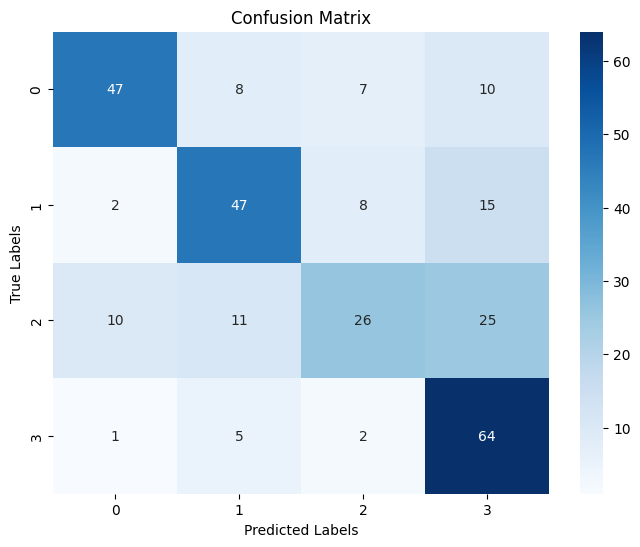

{'Balanced Accuracy': np.float64(0.6388888888888888), "Cohen's Kappa": np.float64(0.5185185185185186), 'Weighted F1-score': 0.6274524563795251}


In [20]:
print(get_performance_from_trainer(trainer, test_dataset))

In [20]:
# For the Pretrained and Finetuned model, nothing change in the model configuration 
trainer_config_PT_FT = config

trainer_config_PT_FT['run_name'] = 'Finetune_PT_FT'
trainer_config_PT_FT['train_dataset'] = train_dataset
trainer_config_PT_FT['validation_dataset'] = validation_dataset
trainer_config_PT_FT['output_dir'] = os.path.join(config_path['log_dir'], trainer_config_PT_FT['run_name'])
trainer_config_PT_FT['training_steps'] = 3000
trainer_config_PT_FT['validation_steps'] = 500
trainer_config_PT_FT['weight_decay'] = 0.1
trainer_config_PT_FT['adam_beta1'] = 0.9
trainer_config_PT_FT['adam_beta2'] = 0.999
trainer_config_PT_FT['adam_epsilon'] = 1e-8
trainer_config_PT_FT['model_save_steps'] = trainer_config_PT_FT["training_steps"]*2
trainer_config_PT_FT['log_every_n_steps'] = 1000
trainer_config_PT_FT['eval_every_n_steps'] = 500
trainer_config_PT_FT['warmup_ratio'] = 0.01

trainer_PT_FT = make_trainer(model_init=lambda: make_model(model_config), config = trainer_config_PT_FT)
trainer_PT_FT.train()
print("End of the training ! ")

FC Layer for Classification created.


/home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/encoder/base.py:178: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Loading pretrained model from /home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/pytorch_model.bin
FC Layer for Classification created.
Loading pretrained model from /home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/pytorch_model.bin


/opt/micromamba/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,1.408300
1000,0.973300
2000,0.693400
3000,0.610200


End of the training ! 


In [21]:
path = "training_logs/Finetune_PT_FT/model_final"
trainer_PT_FT.save_model(path)
# get the performances of the the model PT_FT


perf_PT_FT = get_performance_from_trainer(trainer_PT_FT, test_dataset)
print('Performances of the Pretrained and Fine-tuned Model :', perf_PT_FT)

The model has been saved to :  training_logs/Finetune_PT_FT/model_final


Performances of the Pretrained and Fine-tuned Model : {'Balanced Accuracy': np.float64(0.6388888888888888), 'Cohen s Kappa': np.float64(0.5185185185185186), 'Weighted F1-score': 0.6274524563795251}


In [22]:
### You can look at the previous cell to be able to assess performances of the NOT PRETRAINED but FINE-TUNED model

model_config_NPT_FT = config

# TODO : Adapt the model parameters to the type of model you want to assess (hint : look at the explaination added when we defined model_config in the example pipeline )

# model_config_NPT_FT['pretrained_model'] = ???
# model_config_NPT_FT['freeze_encoder'] = ??? 

# YOUR CODE HERE
model_config_NPT_FT['pretrained_model'] = None
model_config_NPT_FT['freeze_encoder'] = False

# Instanciate the trainer 
trainer_config_NPT_FT = config 
trainer_config_NPT_FT['model_init'] = make_model
trainer_config_NPT_FT['run_name'] = 'Finetune_NPT_FT'
trainer_config_NPT_FT['train_dataset'] = train_dataset
trainer_config_NPT_FT['validation_dataset'] = validation_dataset
trainer_config_NPT_FT['output_dir'] = os.path.join(config_path['log_dir'], trainer_config_NPT_FT['run_name'])
trainer_config_NPT_FT['training_steps'] = 3000
trainer_config_NPT_FT['validation_steps'] = 500
trainer_config_NPT_FT['weight_decay'] = 0.1
trainer_config_NPT_FT['adam_beta1'] = 0.9
trainer_config_NPT_FT['adam_beta2'] = 0.999
trainer_config_NPT_FT['adam_epsilon'] = 1e-8
trainer_config_NPT_FT['model_save_steps'] = trainer_config_NPT_FT["training_steps"]*2
trainer_config_NPT_FT['log_every_n_steps'] = 1000
trainer_config_NPT_FT['eval_every_n_steps'] = 500
trainer_config_NPT_FT['warmup_ratio'] = 0.01

# TODO : compute perf_NPT_FT using the parameter defined above 
#perf_NPT_FT = ????

# YOUR CODE HERE
trainer_NPT_FT = make_trainer(model_init=lambda: make_model(model_config_NPT_FT), config = trainer_config_NPT_FT)
trainer_NPT_FT.train()
print("End of the training ! ")
#trainer_PT_FT.save_model(os.path.join(config_path["log_dir"], trainer_config_PT_FT['run_name'],'model_final'))
# get the performances of the the model PT_FT

perf_NPT_FT = get_performance_from_trainer(trainer_NPT_FT, test_dataset)
print('Performances of the Pretrained and Fine-tuned Model :', perf_NPT_FT)

FC Layer for Classification created.


/home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/encoder/base.py:178: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


FC Layer for Classification created.


/opt/micromamba/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,1.495300
1000,1.108900
2000,0.909500
3000,0.840300


End of the training ! 


Performances of the Pretrained and Fine-tuned Model : {'Balanced Accuracy': np.float64(0.5972222222222223), 'Cohen s Kappa': np.float64(0.4629629629629629), 'Weighted F1-score': 0.5757613066233704}


## Case 3 : Fine-tune only the last layer of the model 

In [23]:
### You can look at the previous cell to be able to assess performances of the NOT PRETRAINED model only fine-tuend on the last layer

model_config_NPT_NFT = config

## TO DO : Adapt the model parameters to the type of model you want to assess (hint : look at the explaination added when we defined model_config in the example pipeline )

# model_config_NPT_NFT['pretrained_model'] = ???
# model_config_NPT_NFT['freeze_encoder'] = ??? 

# YOUR CODE HERE
model_config_NPT_NFT['pretrained_model'] = None
model_config_NPT_NFT['freeze_encoder'] = True

# Instanciate the trainer 
trainer_config_NPT_NFT = config 
trainer_config_NPT_NFT['model_init'] = make_model
trainer_config_NPT_NFT['run_name'] = 'Finetune_NPT_NFT'
trainer_config_NPT_NFT['train_dataset'] = train_dataset
trainer_config_NPT_NFT['validation_dataset'] = validation_dataset
trainer_config_NPT_NFT['output_dir'] = os.path.join(config_path['log_dir'], trainer_config_NPT_NFT['run_name'])
trainer_config_NPT_NFT['training_steps'] = 3000
trainer_config_NPT_NFT['validation_steps'] = 500
trainer_config_NPT_NFT['weight_decay'] = 0.1
trainer_config_NPT_NFT['adam_beta1'] = 0.9
trainer_config_NPT_NFT['adam_beta2'] = 0.999
trainer_config_NPT_NFT['adam_epsilon'] = 1e-8
trainer_config_NPT_NFT['model_save_steps'] = trainer_config_NPT_NFT["training_steps"]*2
trainer_config_NPT_NFT['log_every_n_steps'] = 1000
trainer_config_NPT_NFT['eval_every_n_steps'] = 500
trainer_config_NPT_NFT['warmup_ratio'] = 0.01

# TODO : compute perf_NPT_FT using the parameter defined above 
#perf_NPT_NFT = ????

# YOUR CODE HERE
trainer_NPT_NFT = make_trainer(model_init=lambda: make_model(model_config_NPT_NFT), config = trainer_config_NPT_NFT)

trainer_NPT_NFT.train()
print("End of the training ! ")

perf_NPT_NFT = get_performance_from_trainer(trainer_NPT_NFT, test_dataset)
print('Performances of the NOT Pretrained and NOT Fine-tuned Model :', perf_NPT_NFT)

FC Layer for Classification created.


/home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/encoder/base.py:178: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Frozen Encoder : Only the two last layers will be trained
FC Layer for Classification created.
Frozen Encoder : Only the two last layers will be trained


/opt/micromamba/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,1.495300
1000,1.321300
2000,1.265500
3000,1.248700


End of the training ! 


Performances of the NOT Pretrained and NOT Fine-tuned Model : {'Balanced Accuracy': np.float64(0.46875), 'Cohen s Kappa': np.float64(0.29166666666666663), 'Weighted F1-score': 0.40156439149667944}


### Plot of the performances

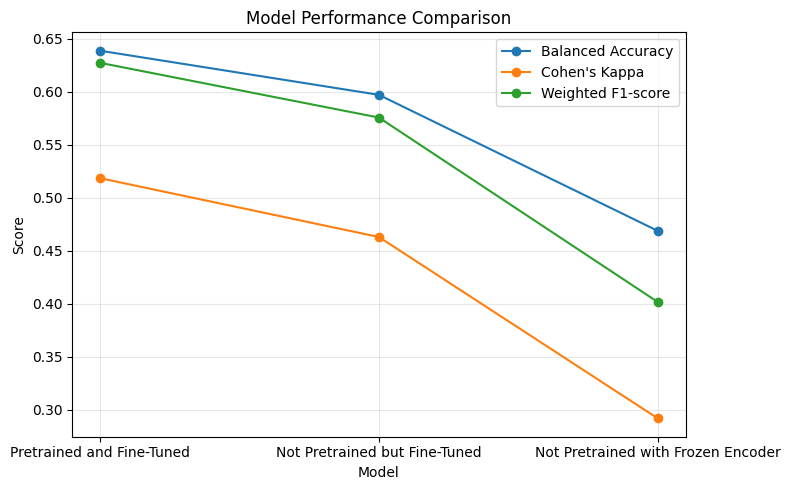

In [24]:
models = ["Pretrained and Fine-Tuned", "Not Pretrained but Fine-Tuned", "Not Pretrained with Frozen Encoder"]

# Extract metrics
balanced_acc = [
    perf_PT_FT['Balanced Accuracy'],
    perf_NPT_FT['Balanced Accuracy'],
    perf_NPT_NFT['Balanced Accuracy']
]

kappa = [
    perf_PT_FT['Cohen s Kappa'],
    perf_NPT_FT['Cohen s Kappa'],
    perf_NPT_NFT['Cohen s Kappa']
]

weighted_f1 = [
    perf_PT_FT['Weighted F1-score'],
    perf_NPT_FT['Weighted F1-score'],
    perf_NPT_NFT['Weighted F1-score']
]

# Plot
plt.figure(figsize=(8,5))

plt.plot(models, balanced_acc, marker='o', label="Balanced Accuracy")
plt.plot(models, kappa, marker='o', label="Cohen's Kappa")
plt.plot(models, weighted_f1, marker='o', label="Weighted F1-score")

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

NeuroGPT paper : https://arxiv.org/abs/2311.03764

NeuroGPT GitHub (the code used in the notebook is derived from it but much simplified) : https://github.com/wenhui0206/NeuroGPT

BCI Competition Datastet paper : https://www.bbci.de/competition/iv/desc_2a.pdf